In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import plotly.offline as py
import plotly.express as px

import plotly.graph_objs as go
import plotly.figure_factory as ff
import cufflinks as cf

cf.set_config_file(offline=True, world_readable=False)

In [6]:
import plotly.io as pio
pio.renderers.default = "colab"

# Introduction

In this lecture we examine the process of data cleaning and Exploratory Data Analysis (EDA).  Often you will acquire or even be given a collection of data in order to conduct some analysis or answer some questions. The first step in using that data is to ensure that it is in the correct form (cleaned) and that you understand its properties and limitations (EDA).  Often as you explore data through EDA you will identify additional transformations that may be required before the data is ready for analysis.

In this notebook we obtain crime data from the city of Berkeley's public records.  Ultimately, our goal might be to understand policing patterns but before we get there we must first clean and understand the data.

# Getting the Data

In [18]:
calls = pd.read_csv("calls_for_service.csv")

# Exploring the data

Now that we have obtained the data we want to understand its:

* **Structure** -- the "shape" of a data file
* **Granularity** -- how fine/coarse is each datum
* **Scope** -- how (in)complete is the data
* **Temporality** -- how is the data situated in time
* **Faithfulness** -- how well does the data capture "reality"



Notice that I used the `repr` function to return the raw string with special characters.  This is helpful in deducing the file format.

### What are some observations about `Stops` data?

This appears to be a fairly standard JSON file.  We notice that the file appears to contain a description of itself in a field called "meta" (which is presumably short for meta-data).  We will come back to this meta data in a moment but first let's quickly discuss the JSON file format.



### A quick note on JSON

[JSON (JavaScript Object Notation)](http://www.json.org) is a common format for exchanging complex structured and semi-structured data.

```javascript
{
    "field1": "value1",
    "field2": ["list", "of", "values"],
    "myfield3": {"is_recursive": true, "a null value": null}
}
```

A few key points:
* JSON is a recursive format in that JSON fields can also contain JSON objects
* JSON closely matches Python Dictionaries:
```python
d = {
    "field1": "value1",
    "field2": ["list", "of", "values"],
    "myfield3": {"is_recursive": True, "a null value": None}
}
print(d['myfield3'])
```
* Very common in web technologies (... JavaScript)
* Many languages have tools for loading and saving JSON objects




## Loading the Data

We will now attempt to load the data into python.  We will be using the Pandas dataframe library for basic tabular data analysis.  Fortunately, the Pandas library has some relatively sophisticated functions for loading data.

How many records did we get?

In [19]:
calls.shape[0]

5227

### Preliminary observations on the data?

1. `EVENTDT` -- Contain the incorrect time stamp
1. `EVENTTM` -- Contains the time in 24 hour format (What timezone?)
1. `CVDOW` -- Appears to be some encoding of the day of the week (see data documentation).
1. `InDbDate` -- Appears to be correctly formatted and appears pretty consistent in time.
1. **`Block_Location` -- Errr, what a mess!  newline characters, and Geocoordinates all merged!!  Fortunately, this field was "quoted" otherwise we would have had trouble parsing the file. (why?)**
1. `BLKADDR` -- This appears to be the address in Block Location.
1. `City` and `State` seem redundant given this is supposed to be the city of Berkeley dataset.


### Checking that the City and State fields are all Berkeley CA

We notice that there are city and state columns.  Since this is supposed to be data for the city of Berkeley these columns appear to be redundant.  Let's quickly compute the number of occurences of unique values for these two columns.

In [22]:
calls.groupby(["City", "State"]).count()

,,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR
City,State,,,,,,,,,
Berkeley,CA,5227,5227,5227,5227,5227,5227,5227,5227,5190


### Decoding day of the week

According to the documentation `CVDOW=0` is Sunday, `CVDOW=1` is Monday, ...,  Therefore we can make a series to decode the day of the week for each record and join that series with the calls data.

In [23]:
dow = pd.Series(["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], name="Day")
dow

0       Sunday
1       Monday
2      Tuesday
3    Wednesday
4     Thursday
5       Friday
6     Saturday
Name: Day, dtype: object

In [24]:
df_dow = pd.DataFrame(dow)
# Notice that I am dropping the column if it already exists to
# make it so I can run this cell more than once
calls = pd.merge(calls.drop(columns="Day", errors="ignore"),
         df_dow, left_on='CVDOW', right_index=True).sort_index()
calls

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day
0,19092769,THEFT MISD. (UNDER $950),12/09/2019 12:00:00 AM,13:00,LARCENY,1,09/10/2020 07:00:11 AM,"SHATTUCK AVE\nBerkeley, CA",SHATTUCK AVE,Berkeley,CA,Monday
1,19045891,NARCOTICS,08/18/2019 12:00:00 AM,17:20,DRUG VIOLATION,0,09/10/2020 07:00:08 AM,"FRONTAGE STREET &GILMAN ST\nBerkeley, CA",FRONTAGE STREET &GILMAN ST,Berkeley,CA,Sunday
2,19060215,ASSAULT/BATTERY MISD.,10/23/2019 12:00:00 AM,10:45,ASSAULT,3,09/10/2020 07:00:10 AM,"2200 MILVIA ST\nBerkeley, CA\n(37.868574, -122...",2200 MILVIA ST,Berkeley,CA,Wednesday
3,19092681,VANDALISM,12/01/2019 12:00:00 AM,18:40,VANDALISM,0,09/10/2020 07:00:11 AM,"VIRGINIA ST\nBerkeley, CA",VIRGINIA ST,Berkeley,CA,Sunday
4,19044228,ASSAULT/BATTERY MISD.,08/10/2019 12:00:00 AM,22:51,ASSAULT,6,09/10/2020 07:00:08 AM,"UNIVERSITY AVENUE &FRONTAGE\nBerkeley, CA",UNIVERSITY AVENUE &FRONTAGE,Berkeley,CA,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...
5222,19092686,BURGLARY AUTO,12/02/2019 12:00:00 AM,08:30,BURGLARY - VEHICLE,1,09/10/2020 07:00:11 AM,"1000 GILMAN ST\nBerkeley, CA\n(37.88014, -122....",1000 GILMAN ST,Berkeley,CA,Monday
5223,19043965,THEFT MISD. (UNDER $950),08/05/2019 12:00:00 AM,23:30,LARCENY,1,09/10/2020 07:00:08 AM,"2300 WARD ST\nBerkeley, CA\n(37.860105, -122.2...",2300 WARD ST,Berkeley,CA,Monday
5224,19052923,BURGLARY AUTO,09/19/2019 12:00:00 AM,13:30,BURGLARY - VEHICLE,4,09/10/2020 07:00:09 AM,"1500 SHATTUCK AV\nBerkeley, CA\n(37.880227, -1...",1500 SHATTUCK AV,Berkeley,CA,Thursday
5225,19049410,DISTURBANCE,08/05/2019 12:00:00 AM,10:00,DISORDERLY CONDUCT,1,09/10/2020 07:00:09 AM,"2900 REGENT ST\nBerkeley, CA\n(37.857787, -122...",2900 REGENT ST,Berkeley,CA,Monday


In [26]:
# Also we can use an other method

calls['CVDOW'] = calls['CVDOW'].replace([0,1,2,3,4,5,6] , ['Sun','Mon','Tue','Wed','Thu','Fri','Sat'])
calls

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day
0,19092769,THEFT MISD. (UNDER $950),12/09/2019 12:00:00 AM,13:00,LARCENY,Mon,09/10/2020 07:00:11 AM,"SHATTUCK AVE\nBerkeley, CA",SHATTUCK AVE,Berkeley,CA,Monday
1,19045891,NARCOTICS,08/18/2019 12:00:00 AM,17:20,DRUG VIOLATION,Sun,09/10/2020 07:00:08 AM,"FRONTAGE STREET &GILMAN ST\nBerkeley, CA",FRONTAGE STREET &GILMAN ST,Berkeley,CA,Sunday
2,19060215,ASSAULT/BATTERY MISD.,10/23/2019 12:00:00 AM,10:45,ASSAULT,Wed,09/10/2020 07:00:10 AM,"2200 MILVIA ST\nBerkeley, CA\n(37.868574, -122...",2200 MILVIA ST,Berkeley,CA,Wednesday
3,19092681,VANDALISM,12/01/2019 12:00:00 AM,18:40,VANDALISM,Sun,09/10/2020 07:00:11 AM,"VIRGINIA ST\nBerkeley, CA",VIRGINIA ST,Berkeley,CA,Sunday
4,19044228,ASSAULT/BATTERY MISD.,08/10/2019 12:00:00 AM,22:51,ASSAULT,Sat,09/10/2020 07:00:08 AM,"UNIVERSITY AVENUE &FRONTAGE\nBerkeley, CA",UNIVERSITY AVENUE &FRONTAGE,Berkeley,CA,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...
5222,19092686,BURGLARY AUTO,12/02/2019 12:00:00 AM,08:30,BURGLARY - VEHICLE,Mon,09/10/2020 07:00:11 AM,"1000 GILMAN ST\nBerkeley, CA\n(37.88014, -122....",1000 GILMAN ST,Berkeley,CA,Monday
5223,19043965,THEFT MISD. (UNDER $950),08/05/2019 12:00:00 AM,23:30,LARCENY,Mon,09/10/2020 07:00:08 AM,"2300 WARD ST\nBerkeley, CA\n(37.860105, -122.2...",2300 WARD ST,Berkeley,CA,Monday
5224,19052923,BURGLARY AUTO,09/19/2019 12:00:00 AM,13:30,BURGLARY - VEHICLE,Thu,09/10/2020 07:00:09 AM,"1500 SHATTUCK AV\nBerkeley, CA\n(37.880227, -1...",1500 SHATTUCK AV,Berkeley,CA,Thursday
5225,19049410,DISTURBANCE,08/05/2019 12:00:00 AM,10:00,DISORDERLY CONDUCT,Mon,09/10/2020 07:00:09 AM,"2900 REGENT ST\nBerkeley, CA\n(37.857787, -122...",2900 REGENT ST,Berkeley,CA,Monday


### Cleaning Block Location

The block location contains the lat/lon coordinates and I might want to use these to analyze the location of each request.  Let's try to extract the GPS coordinates using regular expressions (we will cover regular expressions in future lectures):


In [27]:
calls['Block_Location'].head(10)

0                           SHATTUCK AVE\nBerkeley, CA
1             FRONTAGE STREET &GILMAN ST\nBerkeley, CA
2    2200 MILVIA ST\nBerkeley, CA\n(37.868574, -122...
3                            VIRGINIA ST\nBerkeley, CA
4            UNIVERSITY AVENUE &FRONTAGE\nBerkeley, CA
5                              ASHBY AVE\nBerkeley, CA
6                           CATALINA AVE\nBerkeley, CA
7        CALIFORNIA STREET & FAIRVIEW ST\nBerkeley, CA
8                          600 CANYON RD\nBerkeley, CA
9    1700 FOURTH ST\nBerkeley, CA\n(37.871883, -122...
Name: Block_Location, dtype: object

In [29]:
calls_lat_lon = (
    # Remove newlines
    calls['Block_Location'].str.replace("\n", "\t")
    # Extract Lat and Lon using regular expression
    .str.extract(".*\((?P<Lat>\d*\.\d*)\, (?P<Lon>-?\d*\.\d*)\)", expand=True)
)
calls_lat_lon.head(20)

,Lat,Lon
0,NaN,NaN
1,NaN,NaN
2,37.868574,-122.270415
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,37.871883,-122.301255


Not all the records have a lat and lon.  What fraction do have coordinates?

In [30]:
(~calls_lat_lon.isnull()).mean()

Lat    0.963076
Lon    0.963076
dtype: float64

The following block of code joins the extracted Latitude and Longitude fields with the calls data.  Notice that we actually drop these fields before joining.  This is to enable repeated invocation of this cell even after the join has been completed.

In [33]:
# Remove Lat and Lon if they already existed before (reproducible)
calls.drop(["Lat", "Lon"], axis=1, inplace=True, errors="ignore")
# Join in the the latitude and longitude data
calls = calls.merge(calls_lat_lon, left_index=True, right_index=True)
# calls[["Lat", "Lon"]] = calls_lat_lon
# calls.join(calls_lat_lon)
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day,Lat,Lon
0,19092769,THEFT MISD. (UNDER $950),12/09/2019 12:00:00 AM,13:00,LARCENY,Mon,09/10/2020 07:00:11 AM,"SHATTUCK AVE\nBerkeley, CA",SHATTUCK AVE,Berkeley,CA,Monday,NaN,NaN
1,19045891,NARCOTICS,08/18/2019 12:00:00 AM,17:20,DRUG VIOLATION,Sun,09/10/2020 07:00:08 AM,"FRONTAGE STREET &GILMAN ST\nBerkeley, CA",FRONTAGE STREET &GILMAN ST,Berkeley,CA,Sunday,NaN,NaN
2,19060215,ASSAULT/BATTERY MISD.,10/23/2019 12:00:00 AM,10:45,ASSAULT,Wed,09/10/2020 07:00:10 AM,"2200 MILVIA ST\nBerkeley, CA\n(37.868574, -122...",2200 MILVIA ST,Berkeley,CA,Wednesday,37.868574,-122.270415
3,19092681,VANDALISM,12/01/2019 12:00:00 AM,18:40,VANDALISM,Sun,09/10/2020 07:00:11 AM,"VIRGINIA ST\nBerkeley, CA",VIRGINIA ST,Berkeley,CA,Sunday,NaN,NaN
4,19044228,ASSAULT/BATTERY MISD.,08/10/2019 12:00:00 AM,22:51,ASSAULT,Sat,09/10/2020 07:00:08 AM,"UNIVERSITY AVENUE &FRONTAGE\nBerkeley, CA",UNIVERSITY AVENUE &FRONTAGE,Berkeley,CA,Saturday,NaN,NaN


We can now look at a few of the records that were missing latitude and longitude entries:

In [34]:
calls[calls['Lat'].isnull()].head(10)

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day,Lat,Lon
0,19092769,THEFT MISD. (UNDER $950),12/09/2019 12:00:00 AM,13:00,LARCENY,Mon,09/10/2020 07:00:11 AM,"SHATTUCK AVE\nBerkeley, CA",SHATTUCK AVE,Berkeley,CA,Monday,NaN,NaN
1,19045891,NARCOTICS,08/18/2019 12:00:00 AM,17:20,DRUG VIOLATION,Sun,09/10/2020 07:00:08 AM,"FRONTAGE STREET &GILMAN ST\nBerkeley, CA",FRONTAGE STREET &GILMAN ST,Berkeley,CA,Sunday,NaN,NaN
3,19092681,VANDALISM,12/01/2019 12:00:00 AM,18:40,VANDALISM,Sun,09/10/2020 07:00:11 AM,"VIRGINIA ST\nBerkeley, CA",VIRGINIA ST,Berkeley,CA,Sunday,NaN,NaN
4,19044228,ASSAULT/BATTERY MISD.,08/10/2019 12:00:00 AM,22:51,ASSAULT,Sat,09/10/2020 07:00:08 AM,"UNIVERSITY AVENUE &FRONTAGE\nBerkeley, CA",UNIVERSITY AVENUE &FRONTAGE,Berkeley,CA,Saturday,NaN,NaN
5,19092551,THEFT MISD. (UNDER $950),11/17/2019 12:00:00 AM,12:00,LARCENY,Sun,09/10/2020 07:00:11 AM,"ASHBY AVE\nBerkeley, CA",ASHBY AVE,Berkeley,CA,Sunday,NaN,NaN
6,19047517,BURGLARY AUTO,08/25/2019 12:00:00 AM,18:25,BURGLARY - VEHICLE,Sun,09/10/2020 07:00:08 AM,"CATALINA AVE\nBerkeley, CA",CATALINA AVE,Berkeley,CA,Sunday,NaN,NaN
7,19091711,VANDALISM,08/19/2019 12:00:00 AM,22:00,VANDALISM,Mon,09/10/2020 07:00:08 AM,"CALIFORNIA STREET & FAIRVIEW ST\nBerkeley, CA",CALIFORNIA STREET & FAIRVIEW ST,Berkeley,CA,Monday,NaN,NaN
8,19092111,VANDALISM,09/24/2019 12:00:00 AM,20:00,VANDALISM,Tue,09/10/2020 07:00:09 AM,"600 CANYON RD\nBerkeley, CA",600 CANYON RD,Berkeley,CA,Tuesday,NaN,NaN
67,19043111,DISTURBANCE,08/06/2019 12:00:00 AM,08:55,DISORDERLY CONDUCT,Tue,09/10/2020 07:00:08 AM,"2134 MARTIN LUTHER KING JUNIOR WAY\nBerkeley, CA",2134 MARTIN LUTHER KING JUNIOR WAY,Berkeley,CA,Tuesday,NaN,NaN
164,19066087,DISTURBANCE,11/20/2019 12:00:00 AM,14:14,DISORDERLY CONDUCT,Wed,09/10/2020 07:00:11 AM,MARTIN LUTHER KING JR WAY &ALCATRAZ AVE\nBerke...,MARTIN LUTHER KING JR WAY &ALCATRAZ AVE,Berkeley,CA,Wednesday,NaN,NaN


Are there any patterns to the missing data?

<br/><br/><br/>


---
## Loading the `stops.json` Data

Python has relatively good support for JSON data since it closely matches the internal python object model.  In the following cell we import the entire JSON datafile into a python dictionary.

In [36]:
import json

with open("stops.json", "r") as f:
    stops_json = json.load(f)

In [ ]:
# import json

# file_path = "/content/gdrive/MyDrive/DataScienceCourse/Summer2023KS/lec/lec04/EDA/stops.json"

# try:
#     with open(file_path, "r") as f:
#         content = f.read()
#         if not content:
#             print(f"The file {file_path} is empty.")
#         else:
#             stops_json = json.loads(content)
#             print("JSON file loaded successfully.")
# except FileNotFoundError:
#     print(f"File not found: {file_path}")
# except json.JSONDecodeError as e:
#     print(f"Error decoding JSON in {file_path}: {e}")
# except Exception as e:
#     print(f"An unexpected error occurred: {e}")


JSON file loaded successfully.


The `stops_json` variable is now a dictionary encoding the data in the file:

In [37]:
stops_json

{'meta': {'view': {'id': '4tbf-3yt8',
   'name': 'Berkeley PD - Stop Data (NEW)',
   'attribution': 'City of Berkeley Police Department',
   'averageRating': 0,
   'category': 'Public Safety',
   'createdAt': 1588602591,
   'description': 'This data was extracted from the Departmentâ€™s Public Safety Server and covers data beginning January 26, 2015.  On January 26, 2015 the department began collecting data pursuant to General Order B-4 (issued December 31, 2014). Under that Order, officers were required to provide certain data after making any detention (vehicle, bicycle, pedestrian, suspicious auto).  This dataset provides information about detentions, including the race, sex, age range, of the person detained; the reason for the stop; the type of enforcement taken (if any), and whether or not a search was conducted.  Also provided are the date, time, location of the detention, as well as the incident number and call for service type.',
   'displayType': 'table',
   'downloadCount': 

In [38]:
type(stops_json)

dict

---
<br/><br/><br/>

### We can now examine what keys are in the top level json object

We can list the keys to determine what data is stored in the object.

In [39]:
stops_json.keys()

dict_keys(['meta', 'data'])

#### Observation

The JSON dictionary contains a `meta` key which likely refers to meta data (data about the data).  Meta data often maintained with the data and can be a good source of additional information.

---
<br/><br/><br/>

## Digging into Meta Data

We can investigate the meta data further by examining the keys associated with the metadata.

In [40]:
stops_json['meta'].keys()

dict_keys(['view'])

The `meta` key contains another dictionary called `view`.  This likely refers to meta-data about a particular "view" of some underlying database.  We will learn more about views as we study SQL later in the class.    

In [41]:
stops_json['meta']['view'].keys()

dict_keys(['id', 'name', 'attribution', 'averageRating', 'category', 'createdAt', 'description', 'displayType', 'downloadCount', 'hideFromCatalog', 'hideFromDataJson', 'licenseId', 'newBackend', 'numberOfComments', 'oid', 'provenance', 'publicationAppendEnabled', 'publicationDate', 'publicationGroup', 'publicationStage', 'rowsUpdatedAt', 'rowsUpdatedBy', 'tableId', 'totalTimesRated', 'viewCount', 'viewLastModified', 'viewType', 'approvals', 'columns', 'grants', 'license', 'metadata', 'owner', 'query', 'rights', 'tableAuthor', 'tags', 'flags'])

Notice that this a nested/recursive data structure.  As we dig deeper we reveal more and more keys and the corresponding data:

```
meta
|-> data
    | ... (haven't explored yet)
|-> view
    | -> id
    | -> name
    | -> attribution
    ...
```

There is a key called description in the view sub dictionary.  This likely contains a description of the data:

In [42]:
print(stops_json['meta']['view']['description'])

This data was extracted from the Departmentâ€™s Public Safety Server and covers data beginning January 26, 2015.  On January 26, 2015 the department began collecting data pursuant to General Order B-4 (issued December 31, 2014). Under that Order, officers were required to provide certain data after making any detention (vehicle, bicycle, pedestrian, suspicious auto).  This dataset provides information about detentions, including the race, sex, age range, of the person detained; the reason for the stop; the type of enforcement taken (if any), and whether or not a search was conducted.  Also provided are the date, time, location of the detention, as well as the incident number and call for service type.


---
<br/><br/><br/>

### Columns Meta data

Another potentially useful key in the meta data dictionary is the `columns`.  This returns a list:

In [43]:
type(stops_json['meta']['view']['columns'])

list

We can browse summary data in the list using python:

In [44]:
for c in stops_json['meta']['view']['columns']:
    top = ""
    items = ""
    if "cachedContents" in c:
        top = c["cachedContents"]["top"]
        for i in top:
            items = items + "\n\t" + i["item"] + ":" + i["count"]
    print(c["name"], ":", items)

sid : 
id : 
position : 
created_at : 
created_meta : 
updated_at : 
updated_meta : 
meta : 
CreateDatetime : 
	2015-06-11T06:48:26.000:10
	2020-02-13T08:10:43.000:6
	2017-01-26T11:10:06.000:6
	2020-01-07T08:15:40.000:6
	2016-07-03T23:45:04.000:5
	2015-02-01T19:33:13.000:5
	2016-06-11T19:55:36.000:5
	2015-11-16T07:19:28.000:5
	2016-04-19T00:50:19.000:5
	2016-03-25T01:13:14.000:5
	2017-01-06T00:25:16.000:5
	2016-12-22T23:58:59.000:5
	2016-07-19T02:51:56.000:4
	2015-11-09T22:17:36.000:4
	2015-12-19T02:11:34.000:4
	2016-07-21T02:03:22.000:4
	2017-06-29T02:15:29.000:4
	2018-07-02T21:36:29.000:4
	2016-05-25T01:20:06.000:4
	2016-05-01T01:23:53.000:4
IncidentNumber : 
	2020-00001049:6
	2020-00008547:6
	2015-00033565:5
	2016-00039405:5
	2016-00017339:5
	2016-00075241:5
	2016-00034574:5
	2017-00000828:5
	2015-00033576:5
	2015-00067321:5
	2015-00006347:5
	2016-00022806:5
	2016-00030608:4
	2019-00025759:4
	2016-00049625:4
	2018-00010987:4
	2015-00033137:4
	2017-00045853:4
	2016-00042412:4
	2017-0


### Observations?

1. The above meta data tells us a lot about the columns in the data including column names, potential data anomalies, and a basic statistic.
1. The old version of this data included descriptions which would be useful in loading and working with the data.
1. JSON makes it easier (than CSV) to create "self-documented data".
1. Self documenting data can be helpful since it maintains it's own description and these descriptions are more likely to be updated as data changes.


### Examining the Data Field

We can look at a few entires in the data field


In [45]:
for i in range(3):
    print(i, "\t", stops_json['data'][i])

0 	 ['row-2j6s.qe6z_jtkn', '00000000-0000-0000-D599-E1C6017B6966', 0, 1589533219, None, 1589533219, None, '{ }', '2017-05-02T20:50:29', '2017-00024695', '1275 WALNUT ST', 'BERKELEY', '37.88452086', '-122.268652364', '1194', 'White', 'Female', '30-39', 'Investigation', 'Warning', 'No Search']
1 	 ['row-79rz~ucps-35r6', '00000000-0000-0000-B83C-7A2ADDC55727', 0, 1598605226, None, 1598605226, None, '{ }', '2018-02-20T18:42:04', '2018-00010451', '2176 KITTREDGE ST', 'BERKELEY', '37.868233788', '-122.266394615', '1194', 'White', 'Male', '>40', 'Investigation', 'Other', 'No Search']
2 	 ['row-tmr9_n9ye.6bzh', '00000000-0000-0000-3120-DC62279E5799', 0, 1598605226, None, 1598605226, None, '{ }', '2020-03-04T16:18:11', '2020-00012764', '1414 UNIVERSITY AVE', 'BERKELEY', '37.869690714', '-122.283865643', 'T', 'Black', 'Female', '>40', 'Traffic', 'Citation', 'No Search']


## Building a Dataframe from JSON

In the following block of code we:
1. Translate the JSON records into a dataframe
1. Remove columns that have no metadata description.  This would be a bad idea in general but here we remove these columns since the above analysis suggests that they are unlikely to contain useful information.
1. Examine the top of the table

In [47]:
# Load the data from JSON and assign column titles
stops = pd.DataFrame(
    stops_json['data'],
    columns=[c['name'] for c in stops_json['meta']['view']['columns']])
stops.head()

,sid,id,position,created_at,created_meta,updated_at,updated_meta,meta,CreateDatetime,IncidentNumber,...,City,Lat,Lon,CallType,Race,Gender,Age,Reason,Enforcement,Car Search
0,row-2j6s.qe6z_jtkn,00000000-0000-0000-D599-E1C6017B6966,0,1589533219,None,1589533219,None,{ },2017-05-02T20:50:29,2017-00024695,...,BERKELEY,37.88452086,-122.268652364,1194,White,Female,30-39,Investigation,Warning,No Search
1,row-79rz~ucps-35r6,00000000-0000-0000-B83C-7A2ADDC55727,0,1598605226,None,1598605226,None,{ },2018-02-20T18:42:04,2018-00010451,...,BERKELEY,37.868233788,-122.266394615,1194,White,Male,>40,Investigation,Other,No Search
2,row-tmr9_n9ye.6bzh,00000000-0000-0000-3120-DC62279E5799,0,1598605226,None,1598605226,None,{ },2020-03-04T16:18:11,2020-00012764,...,BERKELEY,37.869690714,-122.283865643,T,Black,Female,>40,Traffic,Citation,No Search
3,row-cjve_43yp_s8ec,00000000-0000-0000-4EEF-F940D151C603,0,1598605226,None,1598605226,None,{ },2018-12-04T15:11:14,2018-00067166,...,BERKELEY,37.867138358,-122.268229602,1196,Hispanic,Male,30-39,Traffic,Warning,No Search
4,row-wxqp_6mgh-v4r5,00000000-0000-0000-8B94-7D86EB47C51D,0,1589533219,None,1589533219,None,{ },2020-05-13T09:37:53,2020-00023435,...,BERKELEY,37.865779797,-122.267576002,1194,Black,Male,>40,Traffic,Citation,No Search


In [48]:
stops.columns

Index(['sid', 'id', 'position', 'created_at', 'created_meta', 'updated_at',
       'updated_meta', 'meta', 'CreateDatetime', 'IncidentNumber', 'Address',
       'City', 'Lat', 'Lon', 'CallType', 'Race', 'Gender', 'Age', 'Reason',
       'Enforcement', 'Car Search'],
      dtype='object')

Too many columns.  Let's ask pandas to show us more.  Be careful, showing too much could break your notebook.

In [49]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [50]:
stops.head(10)

,sid,id,position,created_at,created_meta,updated_at,updated_meta,meta,CreateDatetime,IncidentNumber,Address,City,Lat,Lon,CallType,Race,Gender,Age,Reason,Enforcement,Car Search
0,row-2j6s.qe6z_jtkn,00000000-0000-0000-D599-E1C6017B6966,0,1589533219,None,1589533219,None,{ },2017-05-02T20:50:29,2017-00024695,1275 WALNUT ST,BERKELEY,37.88452086,-122.268652364,1194,White,Female,30-39,Investigation,Warning,No Search
1,row-79rz~ucps-35r6,00000000-0000-0000-B83C-7A2ADDC55727,0,1598605226,None,1598605226,None,{ },2018-02-20T18:42:04,2018-00010451,2176 KITTREDGE ST,BERKELEY,37.868233788,-122.266394615,1194,White,Male,>40,Investigation,Other,No Search
2,row-tmr9_n9ye.6bzh,00000000-0000-0000-3120-DC62279E5799,0,1598605226,None,1598605226,None,{ },2020-03-04T16:18:11,2020-00012764,1414 UNIVERSITY AVE,BERKELEY,37.869690714,-122.283865643,T,Black,Female,>40,Traffic,Citation,No Search
3,row-cjve_43yp_s8ec,00000000-0000-0000-4EEF-F940D151C603,0,1598605226,None,1598605226,None,{ },2018-12-04T15:11:14,2018-00067166,2300 SHATTUCK AVE,BERKELEY,37.867138358,-122.268229602,1196,Hispanic,Male,30-39,Traffic,Warning,No Search
4,row-wxqp_6mgh-v4r5,00000000-0000-0000-8B94-7D86EB47C51D,0,1589533219,None,1589533219,None,{ },2020-05-13T09:37:53,2020-00023435,SHATTUCK AVE / CHANNING WAY,BERKELEY,37.865779797,-122.267576002,1194,Black,Male,>40,Traffic,Citation,No Search
5,row-mf49~8gwk.k6g5,00000000-0000-0000-43A3-D477F3C07872,0,1598605226,None,1598605226,None,{ },2019-04-19T04:53:10,2019-00020838,3400 ADELINE ST,BERKELEY,37.846549841,-122.273012707,1196,Other,Male,18-29,Investigation,Warning,No Search
6,row-zks9-32fu.such,00000000-0000-0000-0073-AF5810C4FB2A,0,1598605226,None,1598605226,None,{ },2016-11-20T04:28:07,2016-00068586,1250 UNIVERSITY AVE,BERKELEY,37.869522906,-122.287045202,1196,Black,Male,>40,Investigation,Warning,No Search
7,row-5rst-vhd2-pwxf,00000000-0000-0000-1169-8943ED935A5C,0,1598605226,None,1598605226,None,{ },2020-01-26T23:35:54,2020-00004974,735 ASHBY AVE,BERKELEY,37.850242359,-122.294539787,T,Other,Female,>40,Traffic,Warning,No Search
8,row-44ny.assv-86xh,00000000-0000-0000-EEBF-C9FBD906B2FF,0,1598605226,None,1598605226,None,{ },2016-12-19T01:40:47,2016-00074453,2887 COLLEGE AVE,BERKELEY,37.858828873,-122.252913485,1194,White,Male,30-39,Investigation,Warning,No Search
9,row-cza5_4r84.ajdc,00000000-0000-0000-1729-EE9C56DE857D,0,1598605226,None,1598605226,None,{ },2017-04-15T22:30:50,2017-00021046,SACRAMENTO ST / HEARST AVE,BERKELEY,37.87214977,-122.282132237,T,Asian,Male,18-29,Traffic,Citation,No Search


## Preliminary Observations

What do we observe so far?

We observe:
1. The `Incident Number` appears to have the year encoded in it - we could potentially use this as a validation check.  
1. The `created_at` and `updated_at` Fields look like they are in milliseconds since January 1, 1970.
1. The `CreateDatetime` Field looks to be formatted in YYYY-MM-DDTHH:MM:SS.  I am guessing T means "Time".
1. The `Age` Field has variable size brackets: 18-29, 30-39, >40.
1. The definition of `CallType` can be found in [Berkeley Police DepartmentCall-Incident Types](https://www.cityofberkeley.info/uploadedFiles/Police/Level_3_-_General/Call-Incident%20Types.pdf): 1194-Pedestrian Stop, 1196-Suspicious Vehicle Stop, T-Traffic Stop
     
Recall the description:

### Stop Data
<img src="stops_desc.png" width=800px />



---

<br/><br/><br/>

# EDA

Now that we have loaded our various data files.  Let's try to understand a bit more about the data by examining properties of individual fields.

In [51]:
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day,Lat,Lon
0,19092769,THEFT MISD. (UNDER $950),12/09/2019 12:00:00 AM,13:00,LARCENY,Mon,09/10/2020 07:00:11 AM,"SHATTUCK AVE\nBerkeley, CA",SHATTUCK AVE,Berkeley,CA,Monday,NaN,NaN
1,19045891,NARCOTICS,08/18/2019 12:00:00 AM,17:20,DRUG VIOLATION,Sun,09/10/2020 07:00:08 AM,"FRONTAGE STREET &GILMAN ST\nBerkeley, CA",FRONTAGE STREET &GILMAN ST,Berkeley,CA,Sunday,NaN,NaN
2,19060215,ASSAULT/BATTERY MISD.,10/23/2019 12:00:00 AM,10:45,ASSAULT,Wed,09/10/2020 07:00:10 AM,"2200 MILVIA ST\nBerkeley, CA\n(37.868574, -122...",2200 MILVIA ST,Berkeley,CA,Wednesday,37.868574,-122.270415
3,19092681,VANDALISM,12/01/2019 12:00:00 AM,18:40,VANDALISM,Sun,09/10/2020 07:00:11 AM,"VIRGINIA ST\nBerkeley, CA",VIRGINIA ST,Berkeley,CA,Sunday,NaN,NaN
4,19044228,ASSAULT/BATTERY MISD.,08/10/2019 12:00:00 AM,22:51,ASSAULT,Sat,09/10/2020 07:00:08 AM,"UNIVERSITY AVENUE &FRONTAGE\nBerkeley, CA",UNIVERSITY AVENUE &FRONTAGE,Berkeley,CA,Saturday,NaN,NaN


---
<br/><br/><br/>

### Are Case Numbers unique?

Case numbers are probably used internally to track individual cases and my reference other data we don't have access to.  However, it is possible that multiple calls could be associated with the same case.  Let's see if the case numbers are all unique.

In [54]:
print("There are", calls['CASENO'].unique().shape[0], "unique case numbers.")
print("There are", calls.shape[0], "calls in the table.")

There are 5227 unique case numbers.
There are 5227 calls in the table.


Are case numbers assigned consecutively.  

In [58]:
calls['CASENO'].sort_values().reset_index(drop=True).iplot(yTitle="Case Number", xTitle="Location in File")

<Axes: >

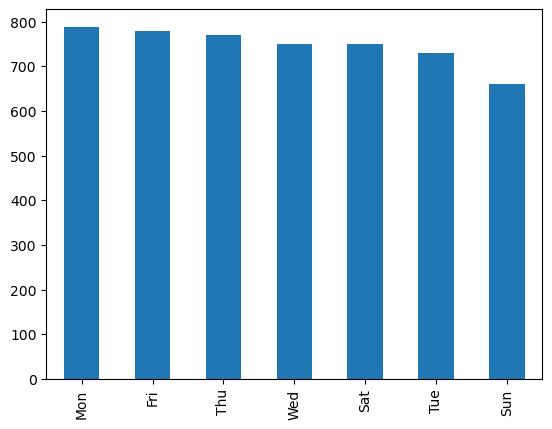

In [72]:
calls['CVDOW'].value_counts().plot(kind = 'bar')

I like to use interactive plotting tools so I can hover the mouse over the plot and read the values.  The cufflinks library adds plotly support to Pandas.  

### What might we be observing?

It looks like there are three discrete regions - an initial value, a consecutive increasing range, a slight gap(!) and another consecutive increasing range.

In [59]:
calls['CASENO'].sort_values().head()

4121    17043531
2204    19010435
4893    19013597
3402    19035723
1587    19035759
Name: CASENO, dtype: int64

Let's look at row 4121.

In [60]:
calls.iloc[[4121]]

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day,Lat,Lon
4121,17043531,SEXUAL ASSAULT FEL.,07/18/2019 12:00:00 AM,00:00,SEX CRIME,Thu,09/10/2020 07:00:08 AM,"UNKNOWN\nBerkeley, CA",UNKNOWN,Berkeley,CA,Thursday,NaN,NaN


This record looks very anomalous as it is missing values for multiple important fields.

---
<br/><br/><br/>

## Examining the Date

Let's dig into the date in which events were recorded.  Notice in this data we have several pieces of date/time information (this is not uncommon):
1. **`EVENTDT`**: This contains the date the event took place.  While it has time information the time appears to be `00:00:00`.  
1. **`EVENTTM`**: This contains the time at which the event took place.
1. **`InDbDate`**: This appears to be the date at which the data was entered in the database.  

In [61]:
calls.head(3)

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day,Lat,Lon
0,19092769,THEFT MISD. (UNDER $950),12/09/2019 12:00:00 AM,13:00,LARCENY,Mon,09/10/2020 07:00:11 AM,"SHATTUCK AVE\nBerkeley, CA",SHATTUCK AVE,Berkeley,CA,Monday,NaN,NaN
1,19045891,NARCOTICS,08/18/2019 12:00:00 AM,17:20,DRUG VIOLATION,Sun,09/10/2020 07:00:08 AM,"FRONTAGE STREET &GILMAN ST\nBerkeley, CA",FRONTAGE STREET &GILMAN ST,Berkeley,CA,Sunday,NaN,NaN
2,19060215,ASSAULT/BATTERY MISD.,10/23/2019 12:00:00 AM,10:45,ASSAULT,Wed,09/10/2020 07:00:10 AM,"2200 MILVIA ST\nBerkeley, CA\n(37.868574, -122...",2200 MILVIA ST,Berkeley,CA,Wednesday,37.868574,-122.270415


When Pandas loads more complex fields like dates it will often load them as strings:

In [62]:
calls["EVENTDT"][0]

'12/09/2019 12:00:00 AM'

We will want to convert these to dates.  Pandas has a fairly sophisticated function `pd.to_datetime` which is capable of guessing reasonable conversions of dates to date objects.

In [63]:
dates = pd.to_datetime(calls["EVENTDT"])
dates[0]

Timestamp('2019-12-09 00:00:00')

We can verify that the translations worked by looking at a few dates:

In [64]:
pd.DataFrame(dict(transformed=dates, original=calls["EVENTDT"])).head()

,transformed,original
0,2019-12-09,12/09/2019 12:00:00 AM
1,2019-08-18,08/18/2019 12:00:00 AM
2,2019-10-23,10/23/2019 12:00:00 AM
3,2019-12-01,12/01/2019 12:00:00 AM
4,2019-08-10,08/10/2019 12:00:00 AM


We can also extract the time field:

In [65]:
times = pd.to_datetime(calls["EVENTTM"]).dt.time
times.head()

0    13:00:00
1    17:20:00
2    10:45:00
3    18:40:00
4    22:51:00
Name: EVENTTM, dtype: object

To combine the correct date and correct time field we use the built-in python datetime combine function.

In [66]:
from datetime import datetime
timestamps = pd.concat([dates, times], axis=1).apply(
    lambda r: datetime.combine(r['EVENTDT'], r['EVENTTM']), axis=1)
timestamps.head()

0   2019-12-09 13:00:00
1   2019-08-18 17:20:00
2   2019-10-23 10:45:00
3   2019-12-01 18:40:00
4   2019-08-10 22:51:00
dtype: datetime64[ns]

We now updated calls to contain this additional informations:

In [67]:
calls['timestamp'] = timestamps
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day,Lat,Lon,timestamp
0,19092769,THEFT MISD. (UNDER $950),12/09/2019 12:00:00 AM,13:00,LARCENY,Mon,09/10/2020 07:00:11 AM,"SHATTUCK AVE\nBerkeley, CA",SHATTUCK AVE,Berkeley,CA,Monday,NaN,NaN,2019-12-09 13:00:00
1,19045891,NARCOTICS,08/18/2019 12:00:00 AM,17:20,DRUG VIOLATION,Sun,09/10/2020 07:00:08 AM,"FRONTAGE STREET &GILMAN ST\nBerkeley, CA",FRONTAGE STREET &GILMAN ST,Berkeley,CA,Sunday,NaN,NaN,2019-08-18 17:20:00
2,19060215,ASSAULT/BATTERY MISD.,10/23/2019 12:00:00 AM,10:45,ASSAULT,Wed,09/10/2020 07:00:10 AM,"2200 MILVIA ST\nBerkeley, CA\n(37.868574, -122...",2200 MILVIA ST,Berkeley,CA,Wednesday,37.868574,-122.270415,2019-10-23 10:45:00
3,19092681,VANDALISM,12/01/2019 12:00:00 AM,18:40,VANDALISM,Sun,09/10/2020 07:00:11 AM,"VIRGINIA ST\nBerkeley, CA",VIRGINIA ST,Berkeley,CA,Sunday,NaN,NaN,2019-12-01 18:40:00
4,19044228,ASSAULT/BATTERY MISD.,08/10/2019 12:00:00 AM,22:51,ASSAULT,Sat,09/10/2020 07:00:08 AM,"UNIVERSITY AVENUE &FRONTAGE\nBerkeley, CA",UNIVERSITY AVENUE &FRONTAGE,Berkeley,CA,Saturday,NaN,NaN,2019-08-10 22:51:00


### What time range does the data represent

In [68]:
calls['timestamp'].min()

Timestamp('2019-07-01 00:00:00')

In [69]:
calls['timestamp'].max()

Timestamp('2019-12-20 01:30:00')

---
<br/><br/><br/>


### Are there any other interesting temporal patterns

Do more calls occur on a particular day of the week?

In [73]:
dow = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
calls.groupby('Day')['CASENO'].count()[dow].iplot(kind='bar', yTitle="Count")

### How about temporal patterns within a day?

In [76]:
calls['hour_of_day'] = (
    calls['timestamp'].dt.hour * 60 + calls['timestamp'].dt.minute ) / 60.

In [79]:
py.iplot(ff.create_distplot([calls['hour_of_day']],group_labels=["Hour"],bin_size=1, show_rug=False))

### Observations?

In the above plot we see the standard pattern of limited activity early in the morning around here 6:00AM.

### Stratified Analysis

To better understand the time of day a report occurs we could stratify the analysis by the day of the week.  To do this we will use box plots.  


In [81]:
px.violin(calls.sort_values("CVDOW"), y="hour_of_day", x="Day", box=True, points="all", hover_name="CVLEGEND")

#### Observations?

There are no very clear patterns here.  However it does appear that weekends have more calls later into the night.

---
<br/><br/><br/>

### Examining the Event

We also have data about the different kinds of crimes being reported

In [82]:
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day,Lat,Lon,timestamp,hour_of_day
0,19092769,THEFT MISD. (UNDER $950),12/09/2019 12:00:00 AM,13:00,LARCENY,Mon,09/10/2020 07:00:11 AM,"SHATTUCK AVE\nBerkeley, CA",SHATTUCK AVE,Berkeley,CA,Monday,NaN,NaN,2019-12-09 13:00:00,13.000000
1,19045891,NARCOTICS,08/18/2019 12:00:00 AM,17:20,DRUG VIOLATION,Sun,09/10/2020 07:00:08 AM,"FRONTAGE STREET &GILMAN ST\nBerkeley, CA",FRONTAGE STREET &GILMAN ST,Berkeley,CA,Sunday,NaN,NaN,2019-08-18 17:20:00,17.333333
2,19060215,ASSAULT/BATTERY MISD.,10/23/2019 12:00:00 AM,10:45,ASSAULT,Wed,09/10/2020 07:00:10 AM,"2200 MILVIA ST\nBerkeley, CA\n(37.868574, -122...",2200 MILVIA ST,Berkeley,CA,Wednesday,37.868574,-122.270415,2019-10-23 10:45:00,10.750000
3,19092681,VANDALISM,12/01/2019 12:00:00 AM,18:40,VANDALISM,Sun,09/10/2020 07:00:11 AM,"VIRGINIA ST\nBerkeley, CA",VIRGINIA ST,Berkeley,CA,Sunday,NaN,NaN,2019-12-01 18:40:00,18.666667
4,19044228,ASSAULT/BATTERY MISD.,08/10/2019 12:00:00 AM,22:51,ASSAULT,Sat,09/10/2020 07:00:08 AM,"UNIVERSITY AVENUE &FRONTAGE\nBerkeley, CA",UNIVERSITY AVENUE &FRONTAGE,Berkeley,CA,Saturday,NaN,NaN,2019-08-10 22:51:00,22.850000


### The Offense Field

The Offense field appears to contain the specific crime being reported.  As nominal data we might want to see a summary constructed by computing counts of each offense type:

<Axes: >

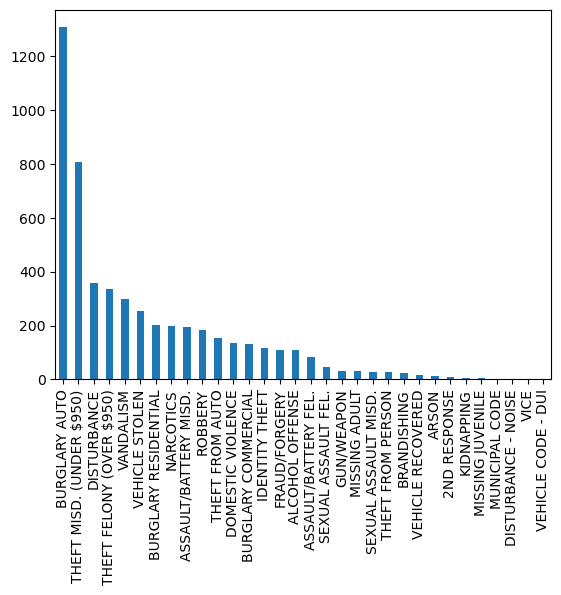

In [84]:
calls['OFFENSE'].value_counts().plot(kind="bar")

#### Observations?

Car burglary and misdemeanor theft seem to be the most common crimes with many other types of crimes occurring rarely.

---
<br/><br/><br/>

### CVLEGEND

The CVLEGEND field provides the broad category of crime and is a good mechanism to group potentially similar crimes.

<Axes: >

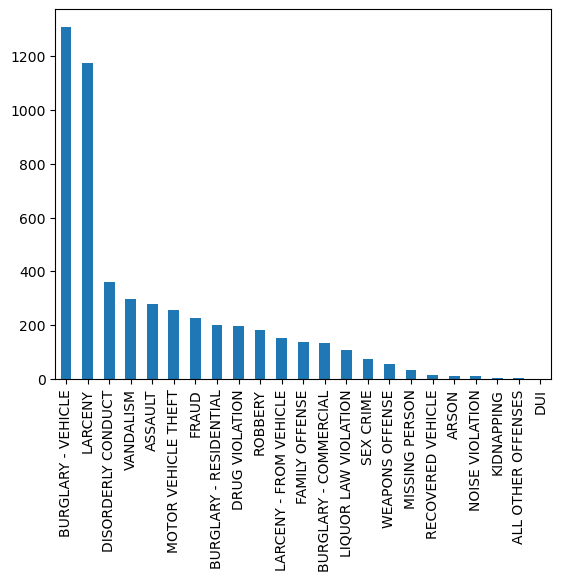

In [86]:
calls['CVLEGEND'].value_counts().plot(kind="bar")

Notice that when we group by the crime time we see that **larceny** emerges as one of the top crimes.  Larceny is essentially stealing -- taking someone else stuff without force.

### Stratified Analysis of Time of Day by CVLEGEND

View the crime time periods broken down by crime type:

In [89]:
boxes = [(len(df), go.Violin(y=df["hour_of_day"], name=i)) for (i, df) in calls.groupby("CVLEGEND")]
py.iplot([r[1] for r in sorted(boxes, key=lambda x:x[0], reverse=True)])

In [92]:
py.iplot(ff.create_distplot([
    calls[calls['CVLEGEND'] == "NOISE VIOLATION"]['hour_of_day'],
    calls[calls['CVLEGEND'] == "DRUG VIOLATION"]['hour_of_day'],
    calls[calls['CVLEGEND'] == "LIQUOR LAW VIOLATION"]['hour_of_day'],
    calls[calls['CVLEGEND'] == "FRAUD"]['hour_of_day']
],
    group_labels=["Noise Violation", "Drug Violation", "Liquor Violation", "Fraud"],
    ))


## Examining Location information

Let's examine the geographic data (latitude and longitude).  Recall that we had some missing values.  Let's look at the behavior of these missing values according to crime type.

<Axes: ylabel='CVLEGEND'>

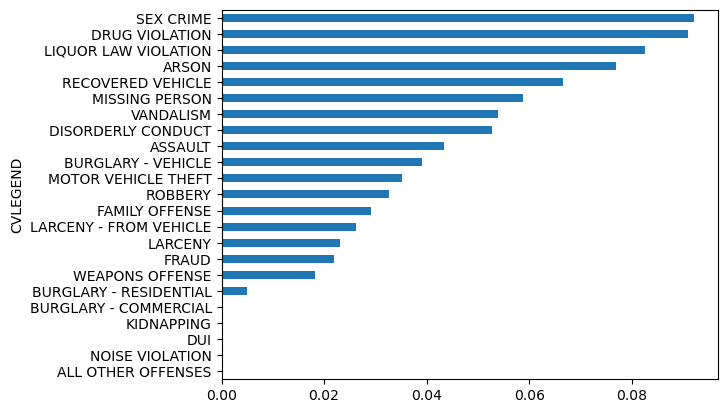

In [95]:
calls["missing_lat_lon"] = calls[['Lat', 'Lon']].isnull().any(axis=1)
calls.groupby("CVLEGEND")['missing_lat_lon'].mean().sort_values().plot(kind="barh")

### Observations?

There is a clear bias towards sex crimes and drug violations that is not present in the original data.  Therefore we should be careful when dropping missing values!

---
<br/><br/><br/>

### Examine data geographically


In [98]:
import folium
import folium.plugins # The Folium Javascript Map Library

SF_COORDINATES = (37.87, -122.28)
sf_map = folium.Map(location=SF_COORDINATES, zoom_start=13)
locs = calls[['Lat', 'Lon']].astype('float').dropna().to_numpy()
heatmap = folium.plugins.HeatMap(locs.tolist(), radius = 10)
sf_map.add_child(heatmap)

### Questions

1. Why are all the calls located on the street and at often at intersections?


In [100]:
cluster = folium.plugins.MarkerCluster()
for _, r in calls[['Lat', 'Lon', 'CVLEGEND']].tail(1000).dropna().iterrows():
    cluster.add_child(
        folium.Marker([float(r["Lat"]), float(r["Lon"])], popup=r['CVLEGEND']))

sf_map = folium.Map(location=SF_COORDINATES, zoom_start=13)
sf_map.add_child(cluster)
sf_map